# Import

In [1]:
import pickle

# math and dataframes
import pandas as pd
import numpy as np

# statistics
from sklearn.metrics import r2_score
from scipy.stats import friedmanchisquare, wilcoxon
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Pipeline and Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

In [2]:
df_predictions = pd.read_pickle('df_predictions.pickle')

In [3]:
# columns for datasets

y_column = 'in_B100'
X_columns = [
    'mode', 'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]
genre_columns = [
    'is_Adult_Standard', 'is_Rock', 'is_R&B', 'is_Country', 'is_Pop',
    'is_Rap', 'is_Alternative', 'is_EDM', 'is_Metal'
]
cluster_columns = ['cluster', 'cluster2']
other_columns = ['key', 'time_signature', 'genre', 'release_date']
prediction_columns = [
    'y_lr', 'y_dt', 'y_knn', 'y_rf', 'y_ab', 'y_lr_tuned', 'y_dt_tuned', 
    'y_cl_1', 'y_cl_2', 'y_genres'
]

# descriptions for scenarios
predictions_dict = {
    'y_lr': 'Logistic Regression - Default Hyperparameters',
    'y_dt': 'Decision Tree - Default Hyperparameters',
    'y_knn': 'K-Nearest Neighbours - Default Hyperparameters',
    'y_rf': 'Random Forest - Default Hyperparameters',
    'y_ab': 'AdaBoost - Default Hyperparameters',
    'y_lr_tuned': 'Logistic Regression - Tuned Hyperparameters',
    'y_dt_tuned': 'Decision Tree - Tuned Hyperparameters',
    'y_cl_1': 'Logistic Regression - Clustered By KMeans Version 1',
    'y_cl_2': 'Logistic Regression - Clustered By KMeans Version 2',
    'y_genres': 'Logistic Regression - Clustered By Genre'
}

# Explore Predictions

In [4]:
df_predictions[prediction_columns].describe().T.iloc[:-1]

,count,unique,top,freq
y_lr,8827719,2,False,5012328
y_dt,8827719,2,False,5759549
y_knn,8827719,2,False,5389246
y_rf,8827719,2,False,5972306
y_ab,8827719,2,False,5368640
y_lr_tuned,8827719,2,False,5015482
y_dt_tuned,8827719,2,False,5730894
y_cl_1,8827719,2,False,5524314
y_cl_2,8827719,2,False,5445396


In [5]:
# where genre data is available
df_predictions[~df_predictions.y_genres.isna()][prediction_columns].describe().T

,count,unique,top,freq
y_lr,2808901,2,False,1632876
y_dt,2808901,2,False,1856456
y_knn,2808901,2,False,1747625
y_rf,2808901,2,False,1934264
y_ab,2808901,2,False,1746821
y_lr_tuned,2808901,2,False,1633972
y_dt_tuned,2808901,2,False,1855688
y_cl_1,2808901,2,False,1792586
y_cl_2,2808901,2,False,1769889
y_genres,2808901,2,False,1693361


In [6]:
# fill na values for y_genres (if not predicted yes, set to no)
df_predictions = df_predictions.fillna(False)  # for plotting genres

# PCA Scatterplots

In [7]:
pca = PCA()
transformer = StandardScaler()

# transform the data
transformed_X = transformer.fit_transform(df_predictions[X_columns])

# get the PCA
pca_data = pca.fit_transform(transformed_X)

In [8]:
df_predictions = pd.concat([
    df_predictions, 
    pd.DataFrame(pca_data).rename({0: 'PCA1', 1: 'PCA2'}, axis=1)[['PCA1', 'PCA2']]
], axis=1)

In [9]:
pd.DataFrame(pca_data).rename({0: 'PCA1', 1: 'PCA2'}, axis=1)[['PCA1', 'PCA2']].describe()

,PCA1,PCA2
count,8827719.000,8827719.000
mean,-0.000,-0.000
std,1.761,1.215
min,-3.878,-5.615
25%,-1.352,-0.834
50%,-0.462,-0.072
75%,1.055,0.781
max,5.945,5.697


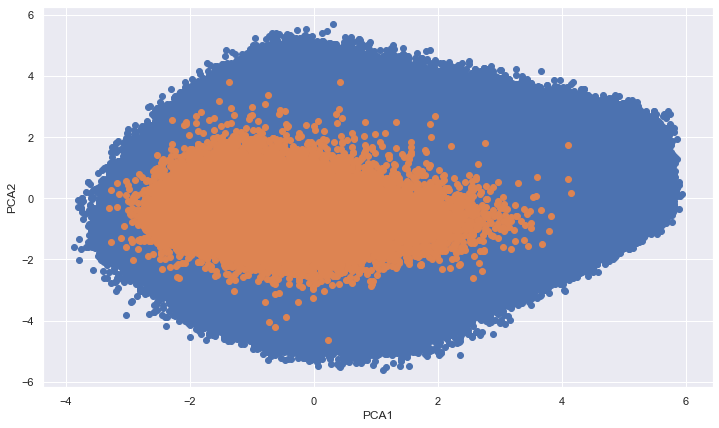

In [10]:
figsize = (12, 7)
plot_x, plot_y = 'PCA1', 'PCA2'
plt.figure(figsize=figsize)
plt.scatter(df_predictions[~df_predictions.in_B100][plot_x], df_predictions[~df_predictions.in_B100][plot_y])
plt.scatter(df_predictions[df_predictions.in_B100][plot_x], df_predictions[df_predictions.in_B100][plot_y])
plt.xlabel(plot_x)
plt.ylabel(plot_y)
plt.show()

In [11]:
def pca_plot(n_scenario, plot_x='PCA1', plot_y='PCA2'):
    
    # evaluated scenarios (with numeric keys)
    scenarios_dict = {
        0: 'Logistic Regression - Default Hyperparameters',
        1: 'Decision Tree - Default Hyperparameters',
        2: 'K-Nearest Neighbours - Default Hyperparameters',
        3: 'Random Forest - Default Hyperparameters',
        4: 'AdaBoost - Default Hyperparameters',
        5: 'Logistic Regression - Tuned Hyperparameters',
        6: 'Decision Tree - Tuned Hyperparameters',
        7: 'Logistic Regression - Clustered By KMeans Version 1',
        8: 'Logistic Regression - Clustered By KMeans Version 2',
        9: 'Logistic Regression - Clustered By Genre'
    }
    print('Comparison of Predicted and Actual Billboard Hits:', scenarios_dict[n_scenario])

    figsize = (12, 7)
    markersize = 15
    alpha = 1

    # setup the plot
    plt.figure(figsize=figsize)
    
    # labels
    if plot_x[:3] == 'PCA':
        xlabel = 'Principal Component '+ plot_x[-1]
    else:
        xlabel = plot_x.title().replace('_', ' ')
    
    if plot_y[:3] == 'PCA':
        ylabel = 'Principal Component '+ plot_y[-1]
    else:
        ylabel = plot_y.title().replace('_', ' ')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # actually no
    plt.scatter(
        df_predictions[~df_predictions.in_B100][plot_x], 
        df_predictions[~df_predictions.in_B100][plot_y], 
        label='Not in Billboard Hot 100', 
        s=markersize,
        alpha=alpha
    )

    # predicted yes
    plt.scatter(
        df_predictions[df_predictions[prediction_columns[n_scenario]]][plot_x], 
        df_predictions[df_predictions[prediction_columns[n_scenario]]][plot_y], 
        color=sns.color_palette()[2], 
        label='Predicted to be Popular', 
        s=markersize,
        alpha=alpha
    )

    # actually yes
    plt.scatter(
        df_predictions[df_predictions.in_B100][plot_x], 
        df_predictions[df_predictions.in_B100][plot_y], 
        color=sns.color_palette()[1],
        label='In Billboard Hot 100', 
        s=markersize,
        alpha=alpha
    )
    
    # legend
    plt.legend(loc='upper right')

    plt.show()
    

Comparison of Predicted and Actual Billboard Hits: Logistic Regression - Default Hyperparameters


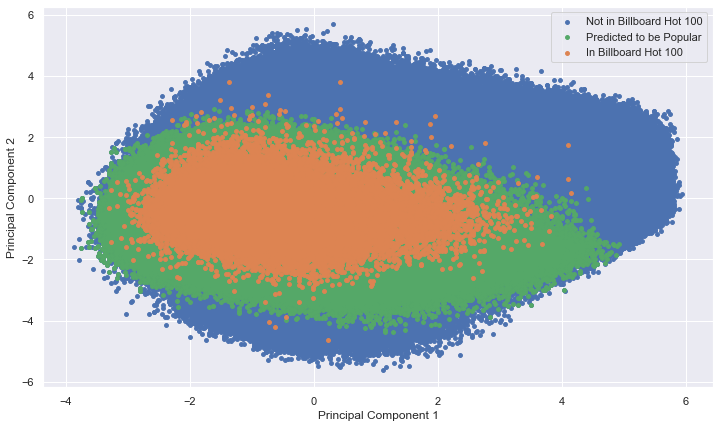

Comparison of Predicted and Actual Billboard Hits: Decision Tree - Default Hyperparameters


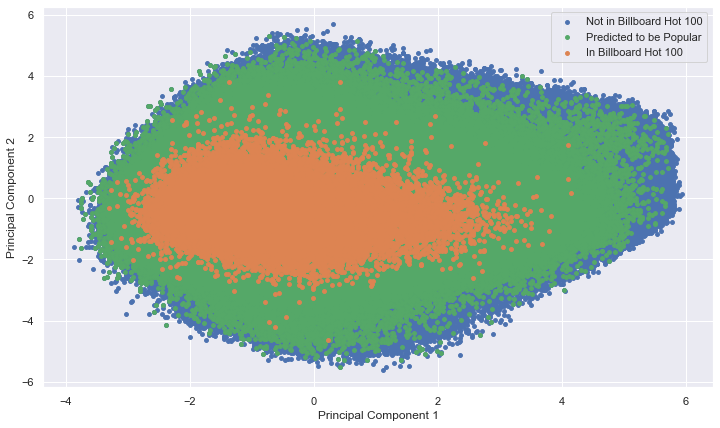

Comparison of Predicted and Actual Billboard Hits: K-Nearest Neighbours - Default Hyperparameters


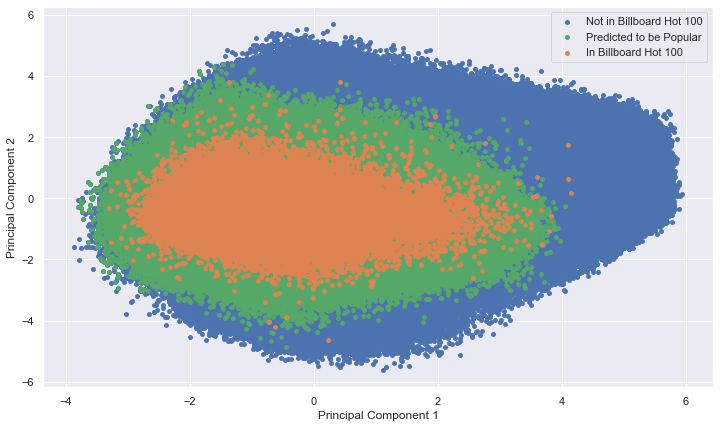

Comparison of Predicted and Actual Billboard Hits: Random Forest - Default Hyperparameters


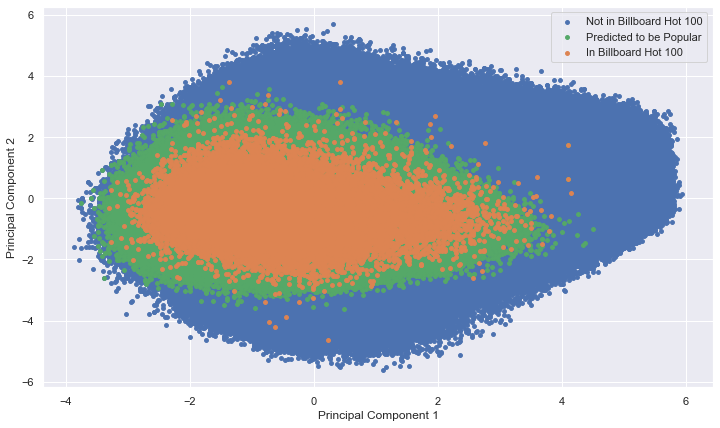

Comparison of Predicted and Actual Billboard Hits: AdaBoost - Default Hyperparameters


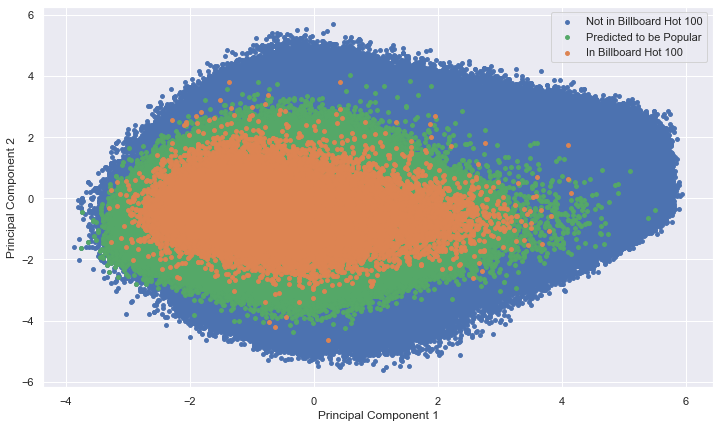

Comparison of Predicted and Actual Billboard Hits: Logistic Regression - Tuned Hyperparameters


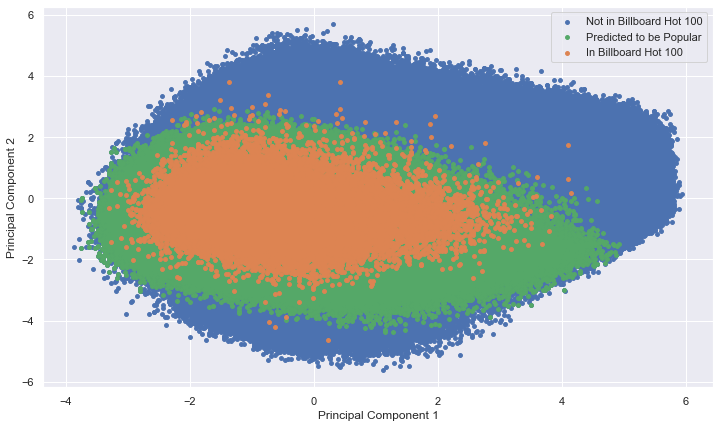

Comparison of Predicted and Actual Billboard Hits: Decision Tree - Tuned Hyperparameters


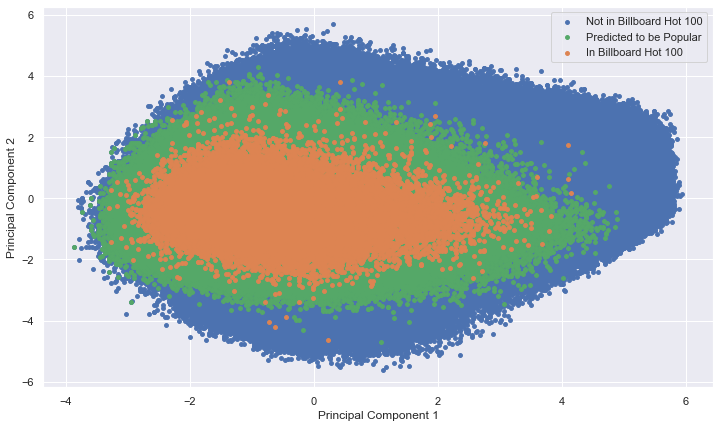

Comparison of Predicted and Actual Billboard Hits: Logistic Regression - Clustered By KMeans Version 1


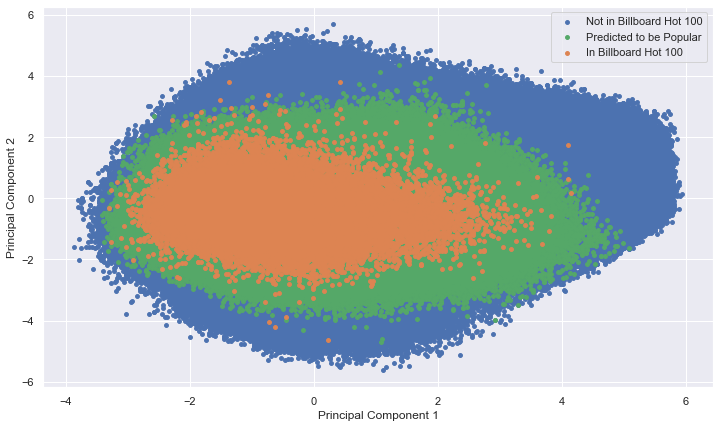

Comparison of Predicted and Actual Billboard Hits: Logistic Regression - Clustered By KMeans Version 2


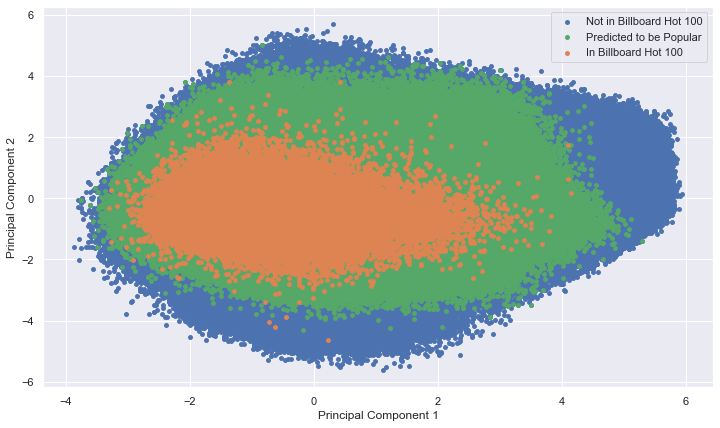

Comparison of Predicted and Actual Billboard Hits: Logistic Regression - Clustered By Genre


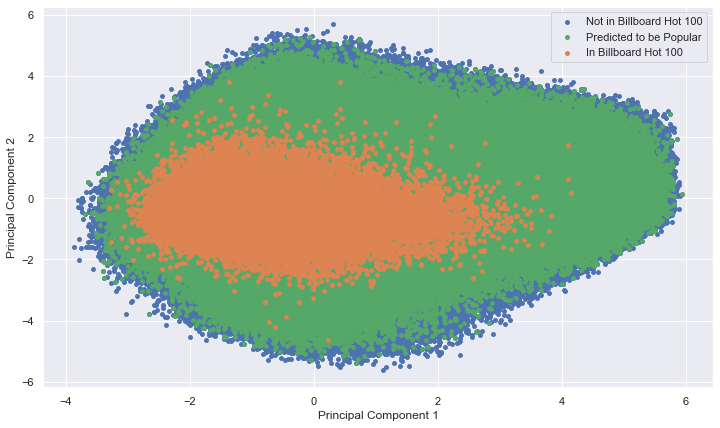

Wall time: 2min 20s


In [12]:
%%time
for i in range(10):
    pca_plot(i)

##### Let's just check to see how this plot would look if we chose 2 audio features

Comparison of Predicted and Actual Billboard Hits: Logistic Regression - Default Hyperparameters


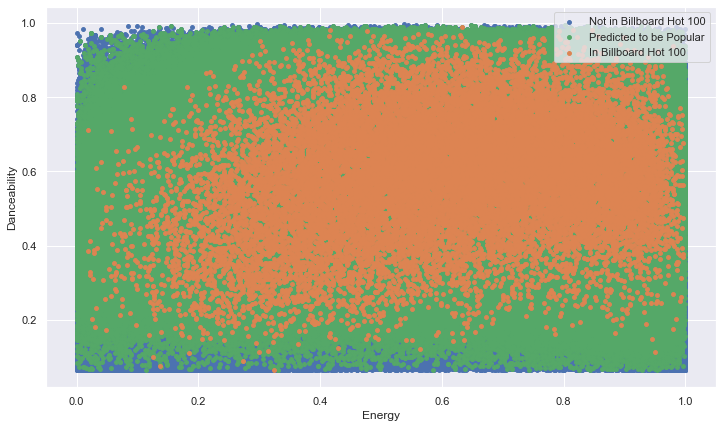

In [13]:
pca_plot(0, 'energy', 'danceability')

# Histograms

Histogram: Principal Component 1


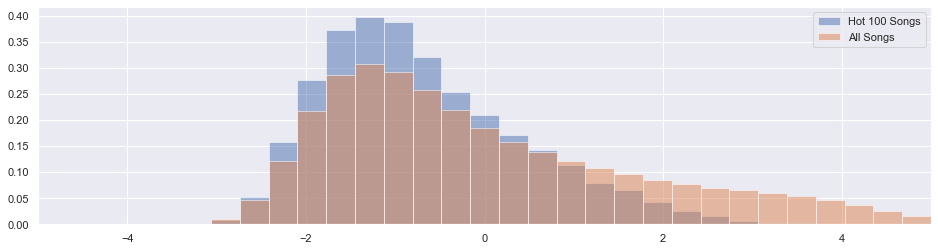

Histogram: Principal Component 2


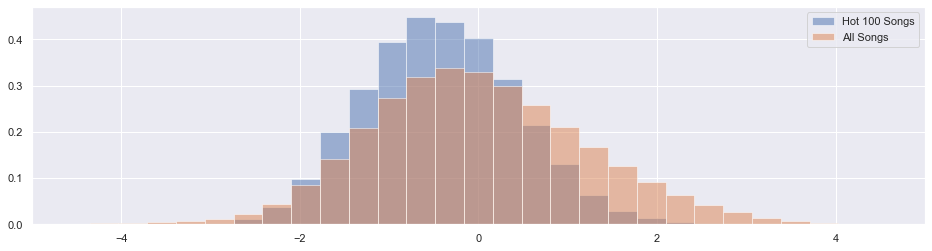

In [14]:
# check histograms for PCA

bins = 30
xmin, xmax = -5, 5
bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)]         
figsize = (16, 4)

print('Histogram: Principal Component 1')

plt.figure(figsize=figsize)
plt.xlim(xmin, xmax)

plt.hist(df_predictions[df_predictions.in_B100]['PCA1'], bins_plot, alpha=0.5, density=True, label='Hot 100 Songs')
plt.hist(df_predictions['PCA1'], bins_plot, alpha=0.5, density=True, label='All Songs')

plt.legend(loc='upper right')
plt.show()

print('Histogram: Principal Component 2')

plt.figure(figsize=figsize)
plt.xlim(xmin, xmax)

plt.hist(df_predictions[df_predictions.in_B100]['PCA2'], bins_plot, alpha=0.5, density=True, label='Hot 100 Songs')
plt.hist(df_predictions['PCA2'], bins_plot, alpha=0.5, density=True, label='All Songs')

plt.legend(loc='upper right')
plt.show()

In [8]:
def compare_histograms(feature, bins=20, logy=False, figsize=(30, 8), xmin=0, xmax=1):
    
    plt.figure(figsize=figsize)
    
    # bins don't line up unless you do this
    plt.xlim(xmin, xmax)
    bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)]
    
    # plots - actual
    plt.hist(df_predictions[df_predictions.in_B100][feature], bins_plot, alpha=0.5, density=True, label='Hot 100 Songs')
    plt.hist(df_predictions[feature], bins_plot, alpha=0.5, density=True, label='All Songs')
    
    # plots - predicitons
    prediction_columns = ['y_lr', 'y_dt', 'y_knn', 'y_rf', 'y_ab', 'y_lr_tuned', 'y_dt_tuned', 'y_cl_1', 'y_cl_2', 'y_genres']
    x_multi = []
    color = []
    for prediction in prediction_columns:
        x_multi.append(df_predictions[df_predictions[prediction]][feature])
        color.append(sns.color_palette()[2])
    
    plt.hist(
        x_multi, 
        bins_plot, 
        alpha=0.7, 
        density=True, 
        label='Predicted Popular',
        color=color,
        edgecolor='white',  #sns.color_palette()[2]
#         ls='dotted',
        rwidth=0.9
    )
    
    title = f'{feature.title()} Histogram: Comparing Hot 100 Songs with Predicted Popularity'
    plt.xlabel(feature.title().replace('_', ' '))
    plt.legend(loc='upper right')
    if logy:
        plt.yscale('log')
        plt.ylabel('Log Relative Frequency')
    else:
        plt.ylabel('Relative Frequency')
    
    # print the title
    print(title)
    
    plt.show()


Acousticness Histogram: Comparing Hot 100 Songs with Predicted Popularity


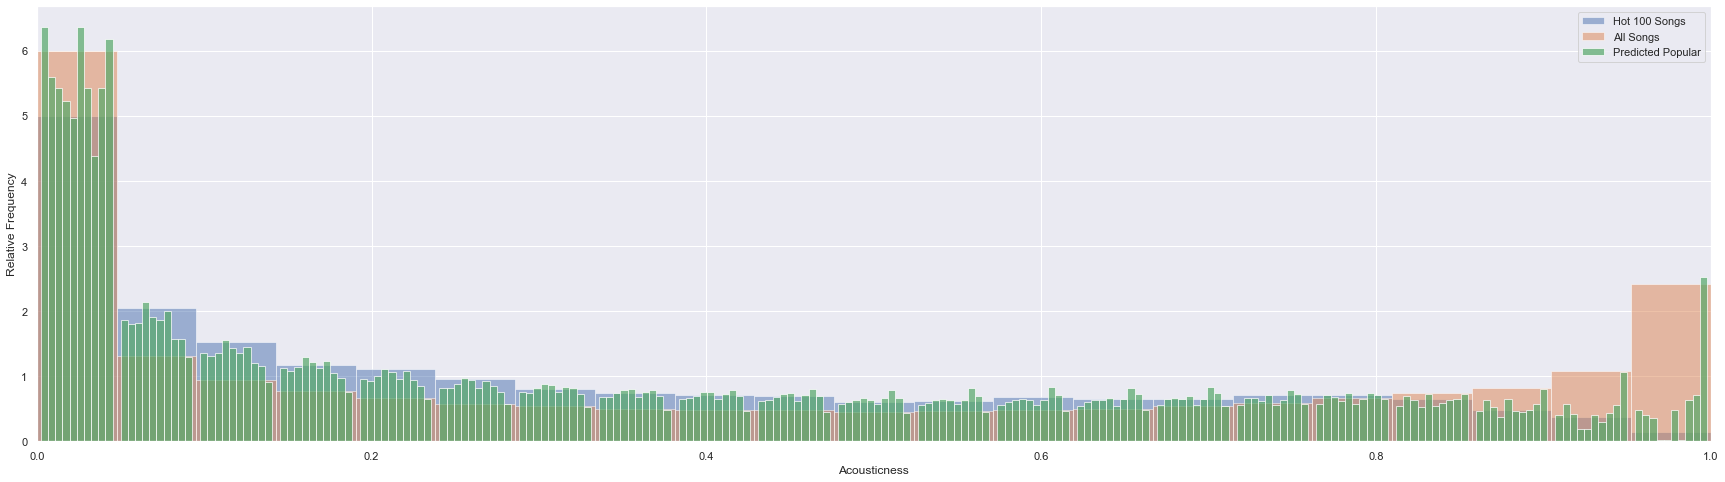

Danceability Histogram: Comparing Hot 100 Songs with Predicted Popularity


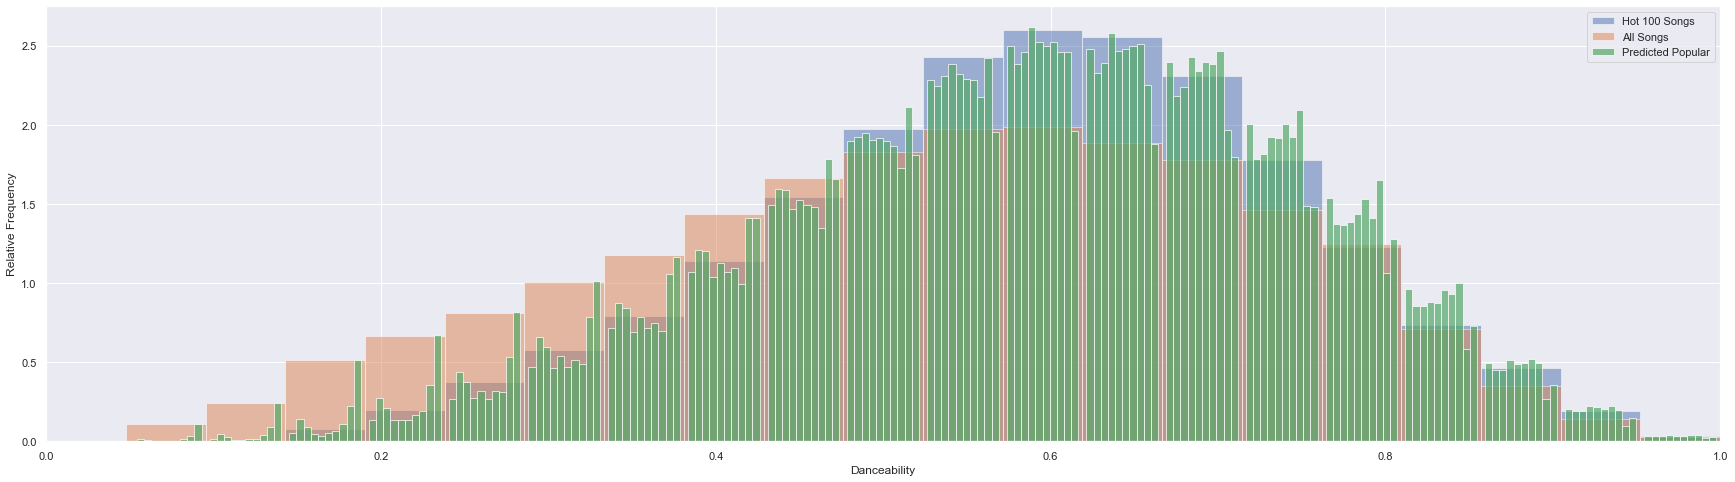

Duration_Ms Histogram: Comparing Hot 100 Songs with Predicted Popularity


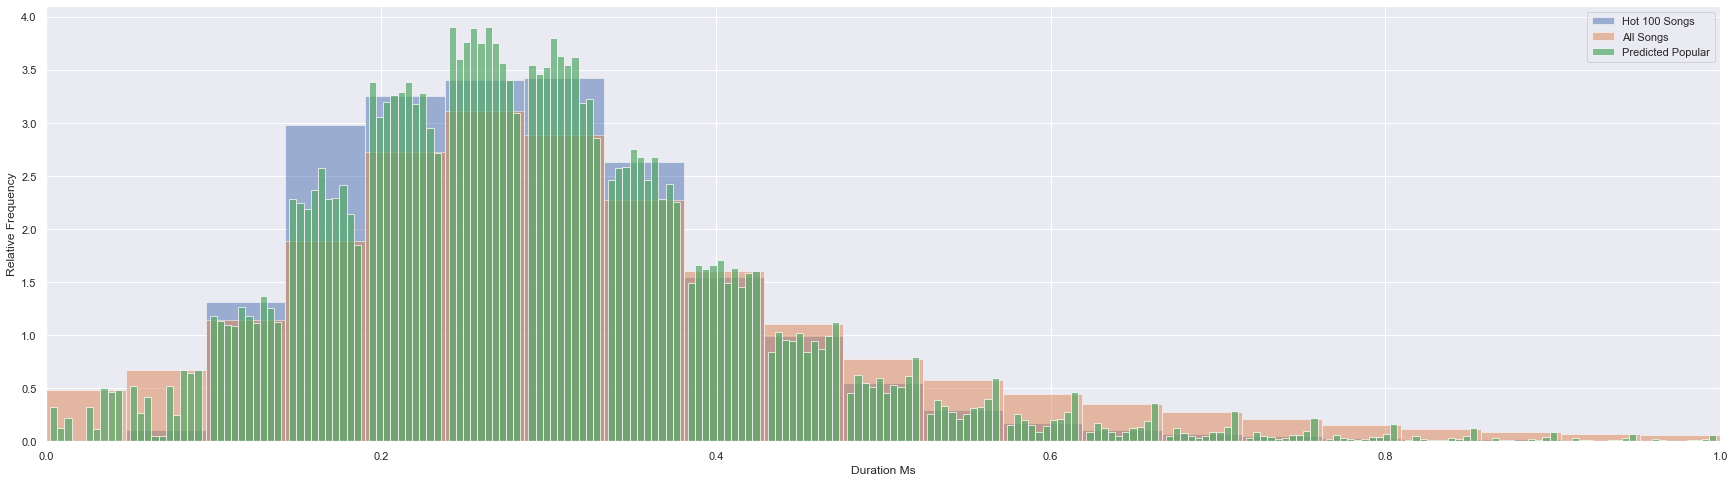

Energy Histogram: Comparing Hot 100 Songs with Predicted Popularity


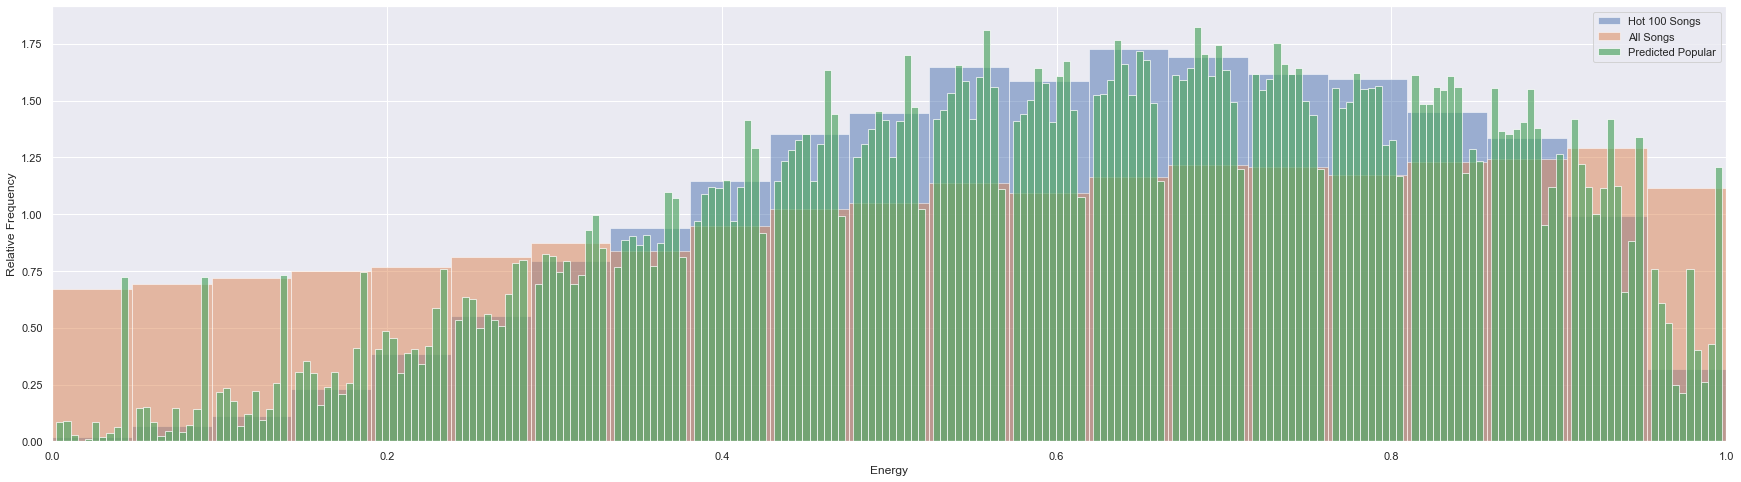

Instrumentalness Histogram: Comparing Hot 100 Songs with Predicted Popularity


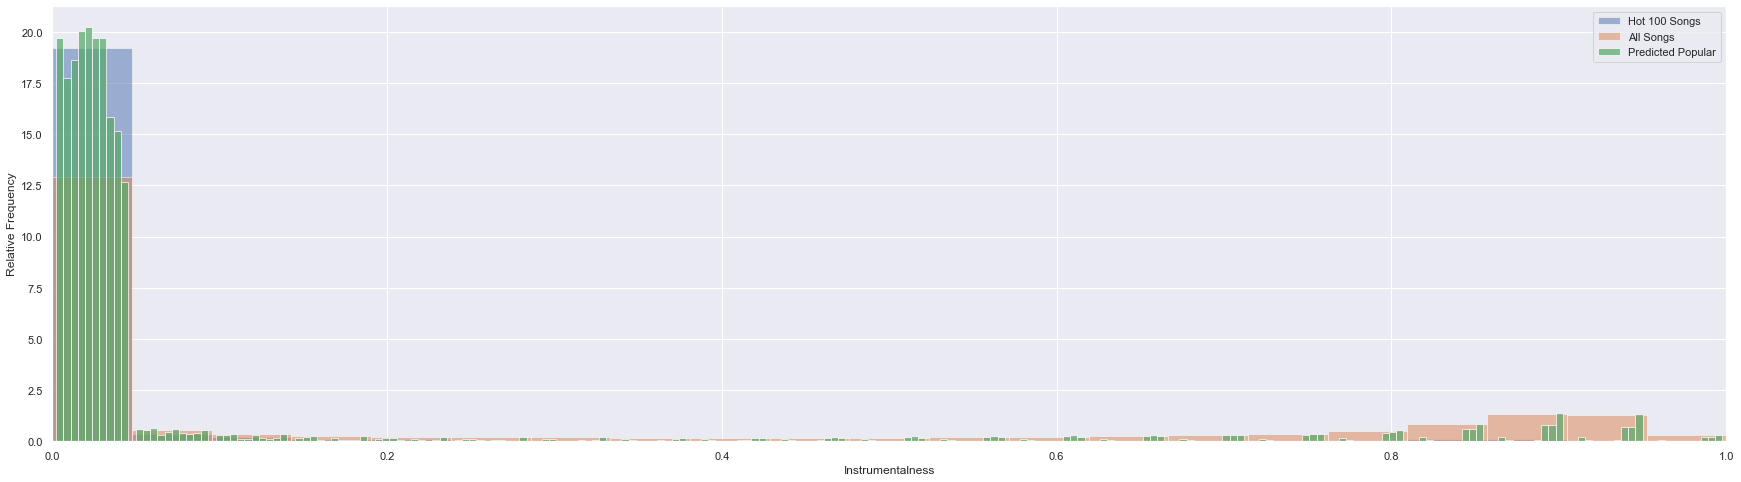

Liveness Histogram: Comparing Hot 100 Songs with Predicted Popularity


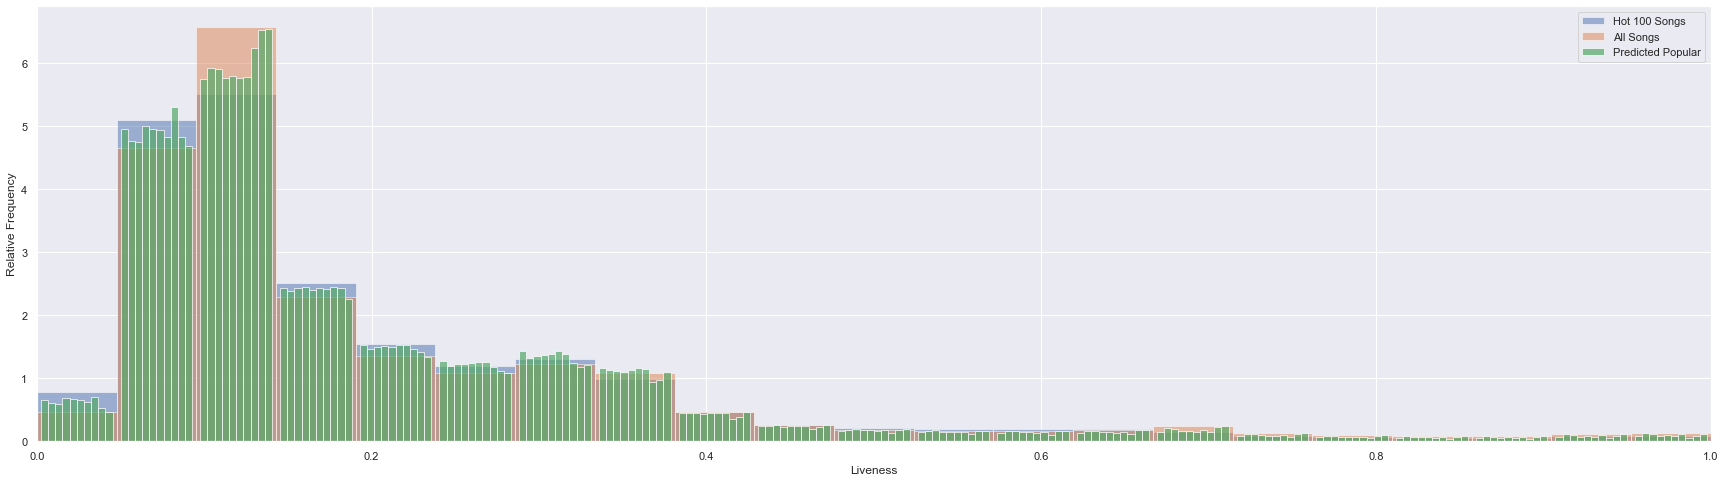

Loudness Histogram: Comparing Hot 100 Songs with Predicted Popularity


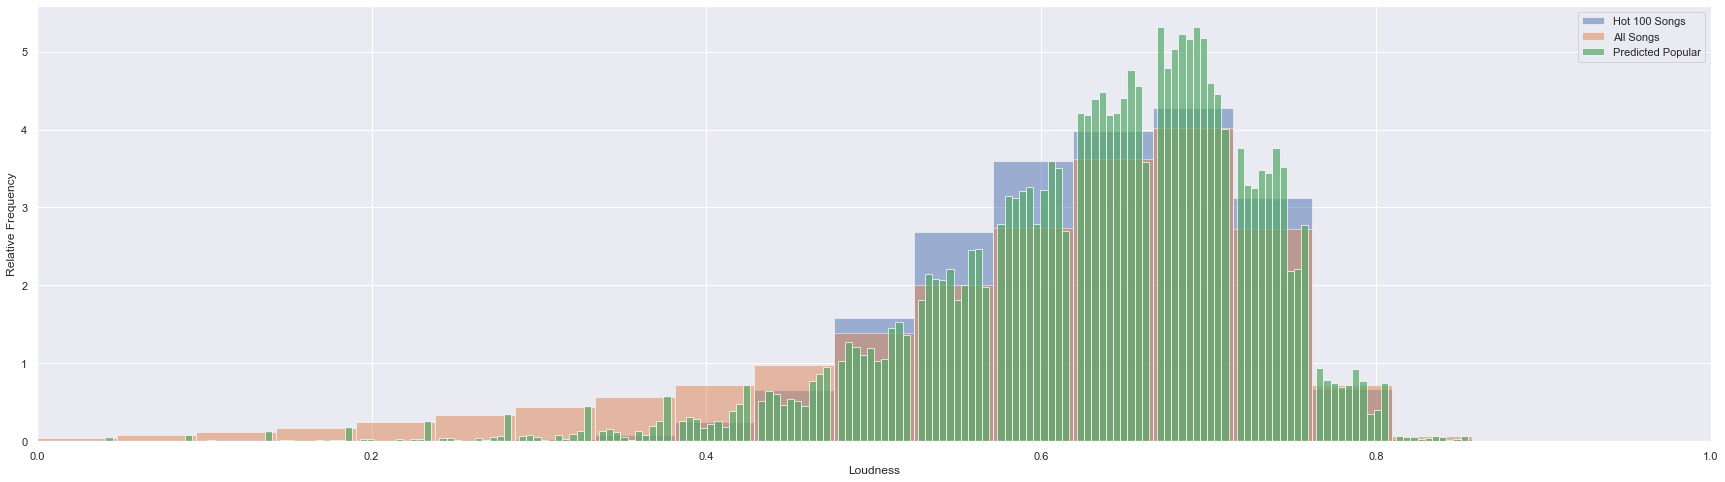

Mode Histogram: Comparing Hot 100 Songs with Predicted Popularity


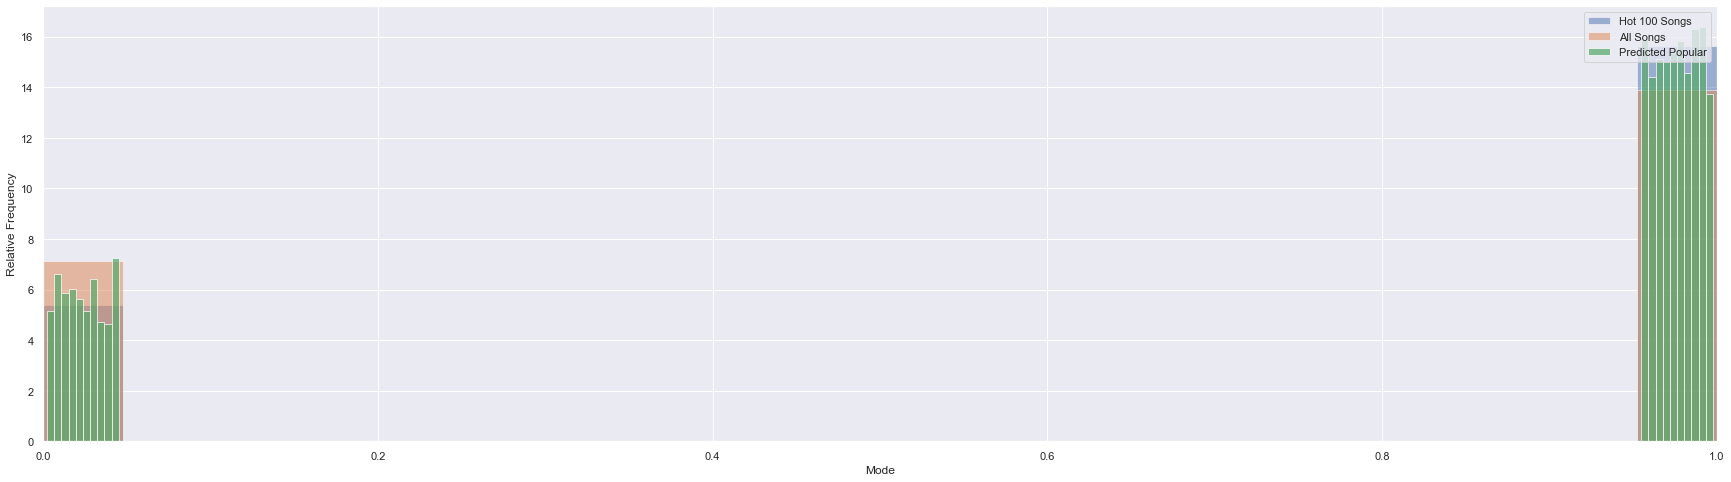

Speechiness Histogram: Comparing Hot 100 Songs with Predicted Popularity


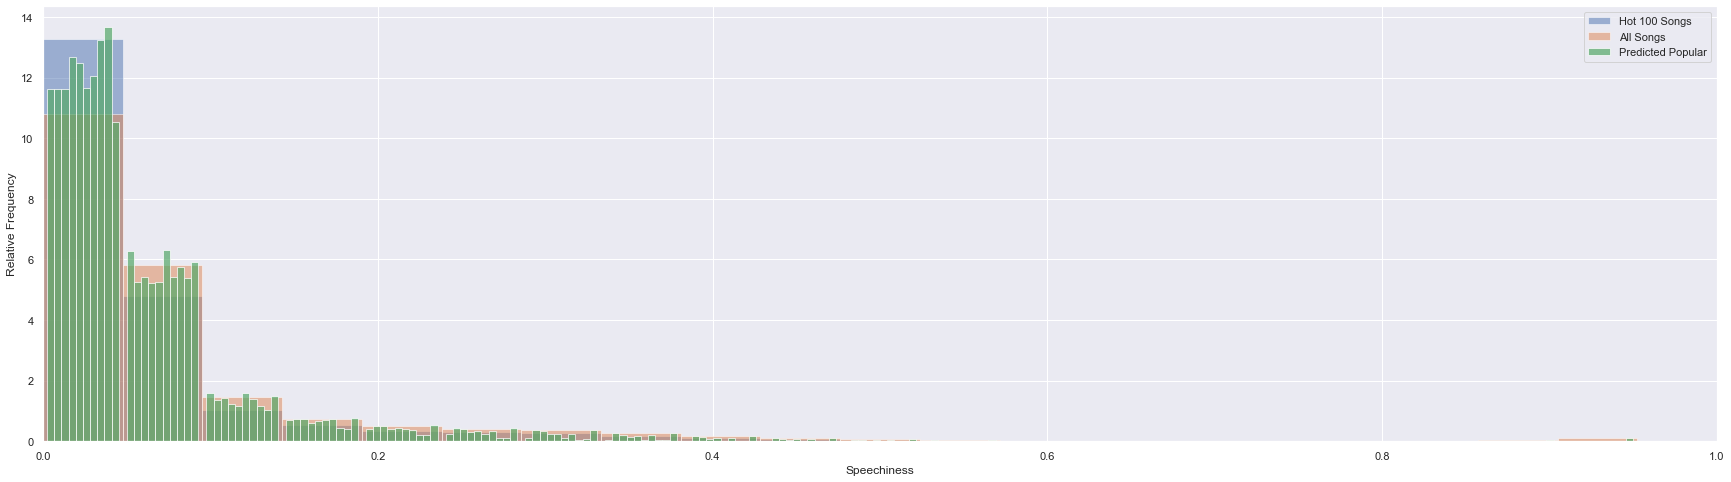

Tempo Histogram: Comparing Hot 100 Songs with Predicted Popularity


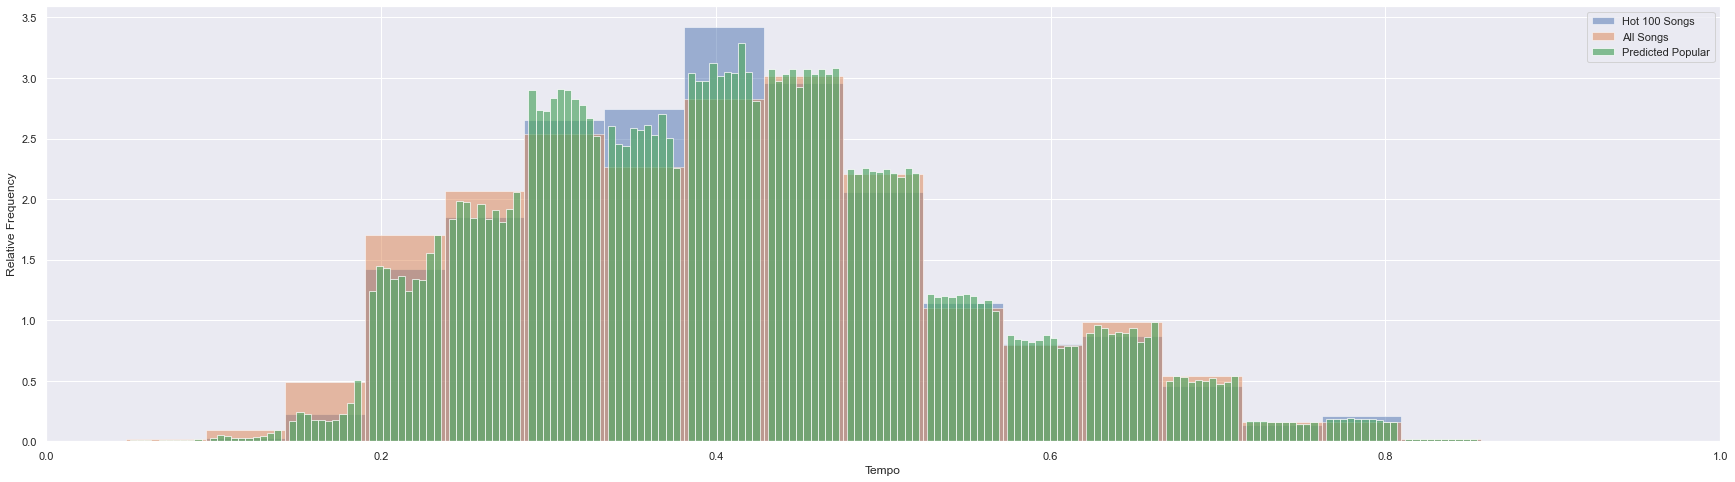

Valence Histogram: Comparing Hot 100 Songs with Predicted Popularity


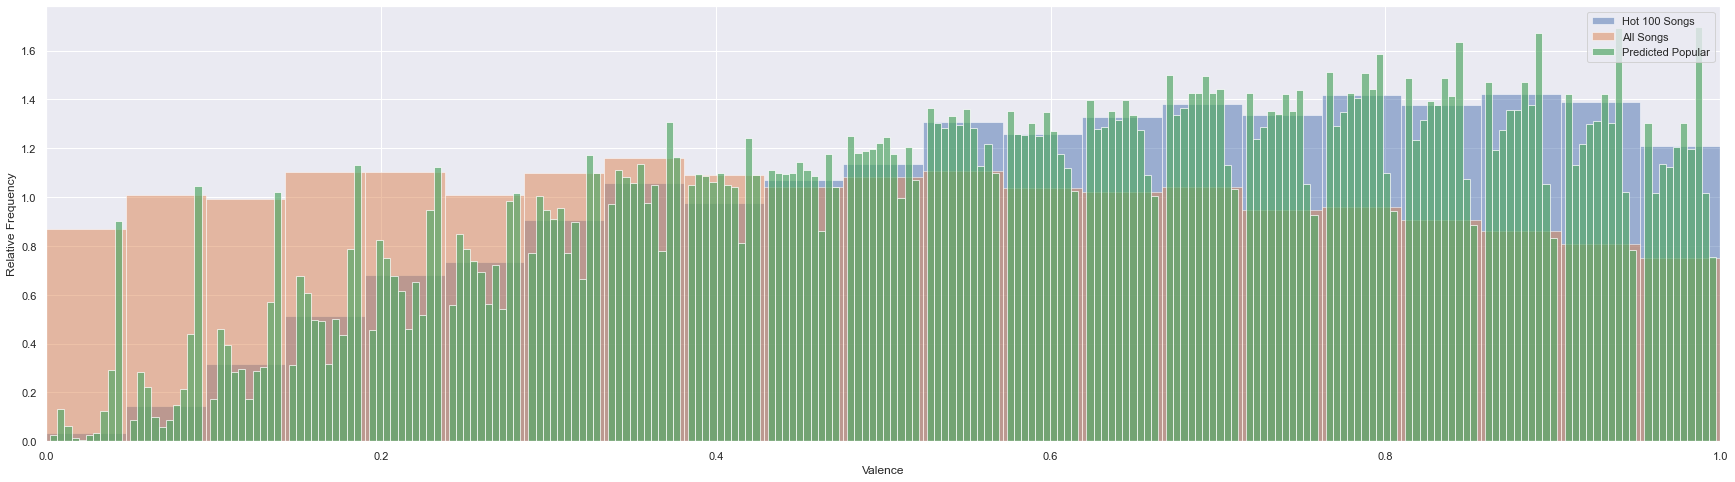

Wall time: 2min 9s


In [22]:
%%time
audio_features = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
    'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence'
]

for feature in audio_features:
    compare_histograms(feature)

Pca1 Histogram: Comparing Hot 100 Songs with Predicted Popularity


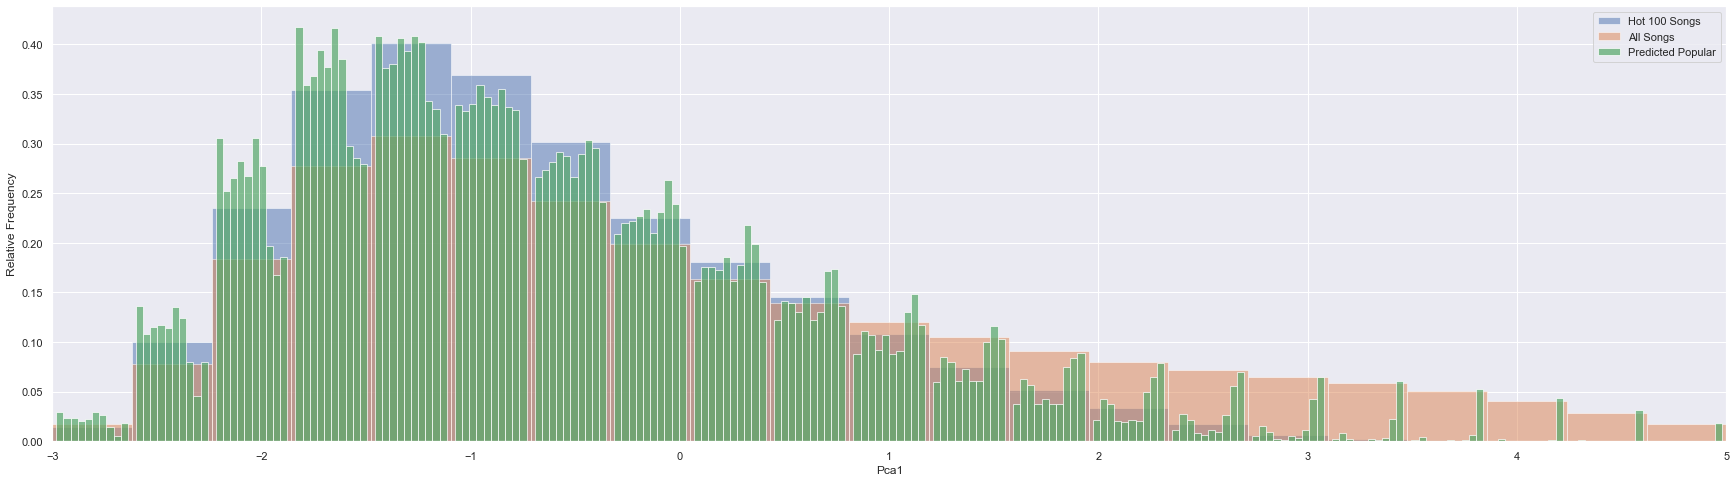

Pca2 Histogram: Comparing Hot 100 Songs with Predicted Popularity


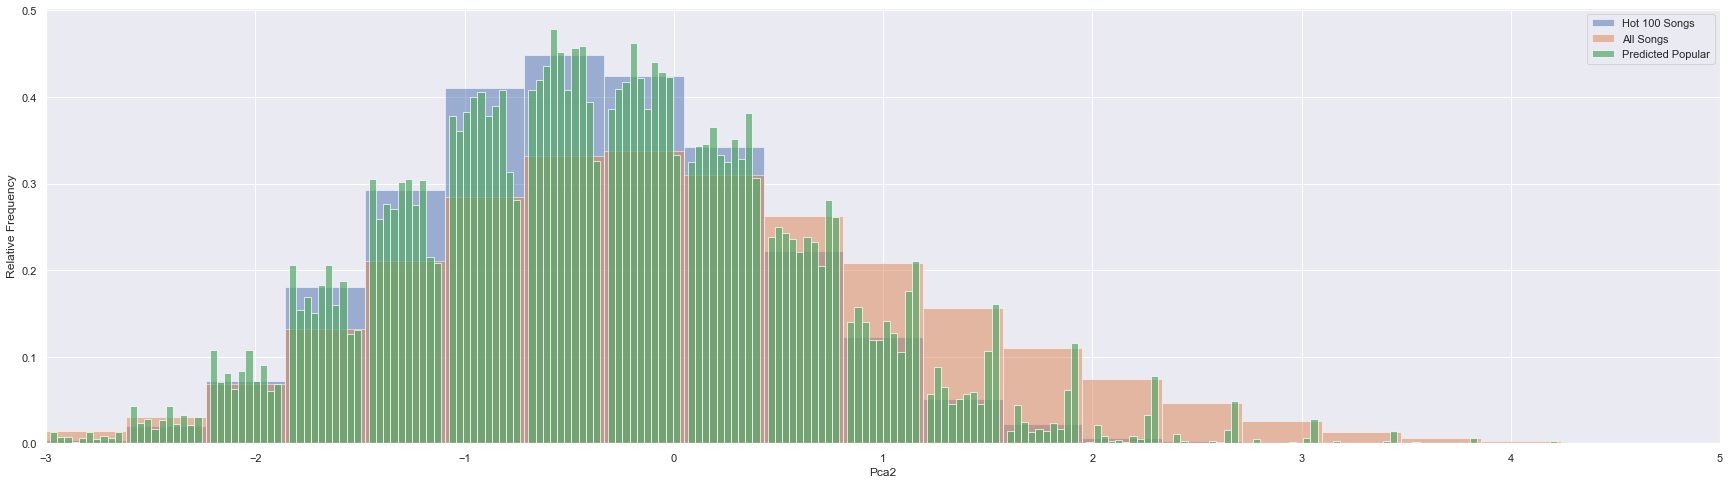

In [23]:
# check principal components
compare_histograms('PCA1', xmin=-3, xmax=5)
compare_histograms('PCA2', xmin=-3, xmax=5)

# Statistics
* Friedman Test (Wilcoxon if required)
* R Squared

### Friedman Test
* REJECT Null Hypothesis
    * to any arbitrary p value
    * prediction methods are not the same

In [29]:
# Friedman Test - Are the models different? to what statistical significance?
friedmanchisquare(*[df_predictions[column] for column in prediction_columns])

FriedmanchisquareResult(statistic=4316978.654631455, pvalue=0.0)

### Wilcoxon Signed Rank Tests
* REJECT Null Hypothesis (except prediction vs itself)
    * to any arbitrary p value
    * no prediction methods are equivalent

In [68]:
predictions_to_columns = [df_predictions[column] for column in prediction_columns]
n_col = len(prediction_columns)

wilcoxon_results = pd.DataFrame(
    np.nan, 
    index=prediction_columns, 
    columns=[x[:6] for x in prediction_columns]  # column names truncated for better spacing
)

for i in range(n_col):
    for j in range(n_col):
        if i == j:
            wilcoxon_results.iloc[i, j] = 1  # p=1 that groups match (i == j)
        else:
            # doesn't work with boolean / categorical values, so multiply by 1 to get 0 or 1s
            wilcoxon_results.iloc[i, j] = wilcoxon(predictions_to_columns[i]*1, predictions_to_columns[j]*1).pvalue
            
wilcoxon_results

,y_lr,y_dt,y_knn,y_rf,y_ab,y_lr_t,y_dt_t,y_cl_1,y_cl_2,y_genr
y_lr,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
y_dt,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
y_knn,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
y_rf,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
y_ab,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
y_lr_tuned,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
y_dt_tuned,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
y_cl_1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
y_cl_2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
y_genres,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


### R Squared
* These results imply that the models are bad, but I'm having trouble interpretting this
* This implies that the results are different than chance
    * but also that the predictions are bad
    * predicting 100% 'No' is the most *accurate* model, but not the *best*

In [79]:
y_true = df_predictions['in_B100']

for prediction in prediction_columns:
    r_squared_score = r2_score(y_true*1, df_predictions[prediction]*1)
    print(
        predictions_dict[prediction], 
        'R-Squared Value: ',
        round(r_squared_score, 1)
    )

Logistic Regression - Default Hyperparameters R-Squared Value:  -178.6
Decision Tree - Default Hyperparameters R-Squared Value:  -143.6
K-Nearest Neighbours - Default Hyperparameters R-Squared Value:  -160.8
Random Forest - Default Hyperparameters R-Squared Value:  -133.2
AdaBoost - Default Hyperparameters R-Squared Value:  -161.7
Logistic Regression - Tuned Hyperparameters R-Squared Value:  -178.4
Decision Tree - Tuned Hyperparameters R-Squared Value:  -144.7
Logistic Regression - Clustered By KMeans Version 1 R-Squared Value:  -154.6
Logistic Regression - Clustered By KMeans Version 2 R-Squared Value:  -158.3
Logistic Regression - Clustered By Genre R-Squared Value:  -52.4


# Which Models Worked The Best?

-------------------------------------------------
 Logistic Regression - Default Hyperparameters
              precision    recall  f1-score   support

       False       1.00      0.57      0.72   8806490
        True       0.00      0.80      0.01     21229

    accuracy                           0.57   8827719
   macro avg       0.50      0.69      0.37   8827719
weighted avg       1.00      0.57      0.72   8827719



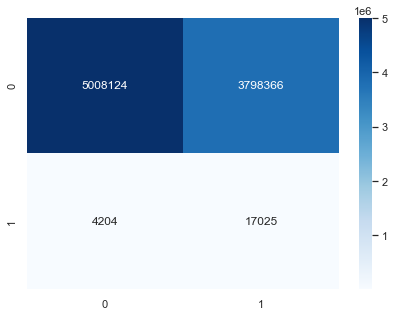

-------------------------------------------------
 Decision Tree - Default Hyperparameters
              precision    recall  f1-score   support

       False       1.00      0.65      0.79   8806490
        True       0.00      0.65      0.01     21229

    accuracy                           0.65   8827719
   macro avg       0.50      0.65      0.40   8827719
weighted avg       1.00      0.65      0.79   8827719



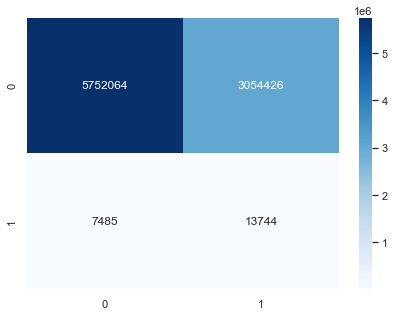

-------------------------------------------------
 K-Nearest Neighbours - Default Hyperparameters
              precision    recall  f1-score   support

       False       1.00      0.61      0.76   8806490
        True       0.00      0.76      0.01     21229

    accuracy                           0.61   8827719
   macro avg       0.50      0.69      0.38   8827719
weighted avg       1.00      0.61      0.76   8827719



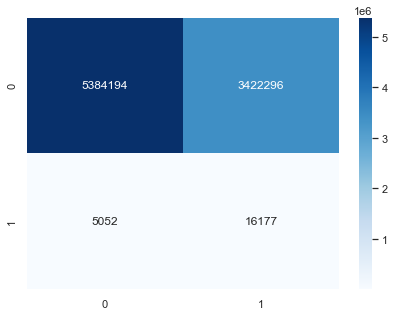

-------------------------------------------------
 Random Forest - Default Hyperparameters
              precision    recall  f1-score   support

       False       1.00      0.68      0.81   8806490
        True       0.01      0.79      0.01     21229

    accuracy                           0.68   8827719
   macro avg       0.50      0.74      0.41   8827719
weighted avg       1.00      0.68      0.81   8827719



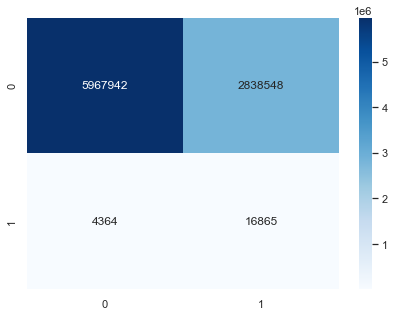

-------------------------------------------------
 AdaBoost - Default Hyperparameters
              precision    recall  f1-score   support

       False       1.00      0.61      0.76   8806490
        True       0.00      0.80      0.01     21229

    accuracy                           0.61   8827719
   macro avg       0.50      0.70      0.38   8827719
weighted avg       1.00      0.61      0.76   8827719



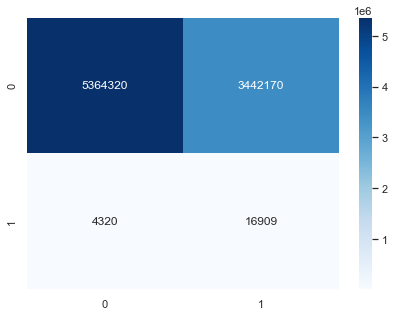

-------------------------------------------------
 Logistic Regression - Tuned Hyperparameters
              precision    recall  f1-score   support

       False       1.00      0.57      0.73   8806490
        True       0.00      0.80      0.01     21229

    accuracy                           0.57   8827719
   macro avg       0.50      0.69      0.37   8827719
weighted avg       1.00      0.57      0.72   8827719



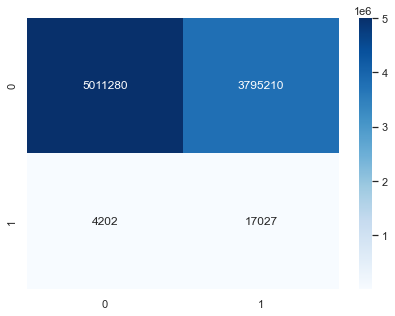

-------------------------------------------------
 Decision Tree - Tuned Hyperparameters
              precision    recall  f1-score   support

       False       1.00      0.65      0.79   8806490
        True       0.01      0.76      0.01     21229

    accuracy                           0.65   8827719
   macro avg       0.50      0.70      0.40   8827719
weighted avg       1.00      0.65      0.79   8827719



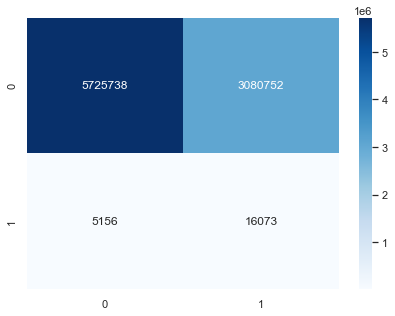

-------------------------------------------------
 Logistic Regression - Clustered By KMeans Version 1
              precision    recall  f1-score   support

       False       1.00      0.63      0.77   8806490
        True       0.00      0.68      0.01     21229

    accuracy                           0.63   8827719
   macro avg       0.50      0.65      0.39   8827719
weighted avg       1.00      0.63      0.77   8827719



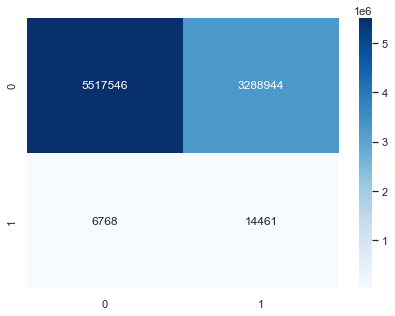

-------------------------------------------------
 Logistic Regression - Clustered By KMeans Version 2
              precision    recall  f1-score   support

       False       1.00      0.62      0.76   8806490
        True       0.00      0.69      0.01     21229

    accuracy                           0.62   8827719
   macro avg       0.50      0.66      0.39   8827719
weighted avg       1.00      0.62      0.76   8827719



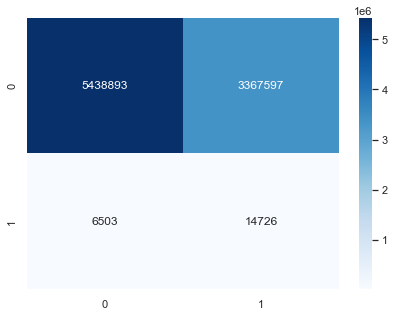

-------------------------------------------------
 Logistic Regression - Clustered By Genre
              precision    recall  f1-score   support

       False       1.00      0.87      0.93   8806490
        True       0.00      0.13      0.00     21229

    accuracy                           0.87   8827719
   macro avg       0.50      0.50      0.47   8827719
weighted avg       1.00      0.87      0.93   8827719



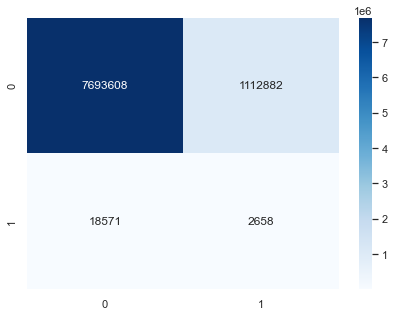

Wall time: 2min 54s


In [102]:
%%time

modelling_results = {}

for prediction in prediction_columns:

    y, y_pred = df_predictions['in_B100'], df_predictions[prediction]

    print('-------------------------------------------------\n', predictions_dict[prediction])

    # classification_report
    modelling_results[prediction] = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    # confusion matrix
    plt.figure(figsize=(7,5))
    sns.heatmap(
        confusion_matrix(y, y_pred), 
        cmap='Blues', 
        annot=True, 
        fmt='.0f'
    )
    plt.show()

In [117]:
%%time
# calculate precision, recall, f1, and accuracy for each model, save to a dataframe

results_metrics = {}

for prediction in prediction_columns:
    precision = modelling_results[prediction]['True']['precision']
    recall = modelling_results[prediction]['True']['recall']
    f1 = modelling_results[prediction]['True']['f1-score']
    accuracy = modelling_results[prediction]['accuracy']

    results_metrics[predictions_dict[prediction]] = [precision, recall, f1, accuracy]
    
results_metrics = pd.DataFrame(results_metrics, index=['Precision', 'Recall', 'F1 Score', 'Accuracy']).T

Wall time: 1.99 ms


In [119]:
# sorted by precision
results_metrics.sort_values('Precision', ascending=False)

,Precision,Recall,F1 Score,Accuracy
Random Forest - Default Hyperparameters,0.006,0.794,0.012,0.678
Decision Tree - Tuned Hyperparameters,0.005,0.757,0.010,0.650
AdaBoost - Default Hyperparameters,0.005,0.797,0.010,0.610
K-Nearest Neighbours - Default Hyperparameters,0.005,0.762,0.009,0.612
Decision Tree - Default Hyperparameters,0.004,0.647,0.009,0.653
Logistic Regression - Tuned Hyperparameters,0.004,0.802,0.009,0.570
Logistic Regression - Default Hyperparameters,0.004,0.802,0.009,0.569
Logistic Regression - Clustered By KMeans Version 1,0.004,0.681,0.009,0.627
Logistic Regression - Clustered By KMeans Version 2,0.004,0.694,0.009,0.618
Logistic Regression - Clustered By Genre,0.002,0.125,0.005,0.872


In [118]:
# sorted by recall
results_metrics.sort_values('Recall', ascending=False)

,Precision,Recall,F1 Score,Accuracy
Logistic Regression - Tuned Hyperparameters,0.004,0.802,0.009,0.570
Logistic Regression - Default Hyperparameters,0.004,0.802,0.009,0.569
AdaBoost - Default Hyperparameters,0.005,0.797,0.010,0.610
Random Forest - Default Hyperparameters,0.006,0.794,0.012,0.678
K-Nearest Neighbours - Default Hyperparameters,0.005,0.762,0.009,0.612
Decision Tree - Tuned Hyperparameters,0.005,0.757,0.010,0.650
Logistic Regression - Clustered By KMeans Version 2,0.004,0.694,0.009,0.618
Logistic Regression - Clustered By KMeans Version 1,0.004,0.681,0.009,0.627
Decision Tree - Default Hyperparameters,0.004,0.647,0.009,0.653
Logistic Regression - Clustered By Genre,0.002,0.125,0.005,0.872


In [120]:
# sorted by f1 score
results_metrics.sort_values('F1 Score', ascending=False)

,Precision,Recall,F1 Score,Accuracy
Random Forest - Default Hyperparameters,0.006,0.794,0.012,0.678
Decision Tree - Tuned Hyperparameters,0.005,0.757,0.010,0.650
AdaBoost - Default Hyperparameters,0.005,0.797,0.010,0.610
K-Nearest Neighbours - Default Hyperparameters,0.005,0.762,0.009,0.612
Decision Tree - Default Hyperparameters,0.004,0.647,0.009,0.653
Logistic Regression - Tuned Hyperparameters,0.004,0.802,0.009,0.570
Logistic Regression - Default Hyperparameters,0.004,0.802,0.009,0.569
Logistic Regression - Clustered By KMeans Version 1,0.004,0.681,0.009,0.627
Logistic Regression - Clustered By KMeans Version 2,0.004,0.694,0.009,0.618
Logistic Regression - Clustered By Genre,0.002,0.125,0.005,0.872


In [121]:
# sorted by accuracy
results_metrics.sort_values('Accuracy', ascending=False)

,Precision,Recall,F1 Score,Accuracy
Logistic Regression - Clustered By Genre,0.002,0.125,0.005,0.872
Random Forest - Default Hyperparameters,0.006,0.794,0.012,0.678
Decision Tree - Default Hyperparameters,0.004,0.647,0.009,0.653
Decision Tree - Tuned Hyperparameters,0.005,0.757,0.010,0.650
Logistic Regression - Clustered By KMeans Version 1,0.004,0.681,0.009,0.627
Logistic Regression - Clustered By KMeans Version 2,0.004,0.694,0.009,0.618
K-Nearest Neighbours - Default Hyperparameters,0.005,0.762,0.009,0.612
AdaBoost - Default Hyperparameters,0.005,0.797,0.010,0.610
Logistic Regression - Tuned Hyperparameters,0.004,0.802,0.009,0.570
Logistic Regression - Default Hyperparameters,0.004,0.802,0.009,0.569


# Future Work
* use PCA to define ranges for audio features which are more likley to be popular
    * https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com